# Georgia
We will be analyzing the congressional district maps in Georgia followwing the 2020 census. Currently Georgia's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election. We will be looking at their 2021 plan which was used for the 2022 election and then a new 2023 plan which was used in the 2024 election. The 2023 plan was a placeholder to fix some of the issues with the 2021 so the 2024 election would have a less problematic map.

## Import Required Packages

In [14]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Analysis of maps by senate voting

Now that we have set up the data, we can start our analysis!

We want to determine what party would have won the election for the U.S. House of Representative in each district for each of the two maps we have for Georgia. However, instead of using House candidates, we will be using U.S. Senate candidates because those were elected across the whole state. Thus, we will be using the Senate election as a placeholder for the House election because in the next party, once we move the congressional district boundary using a random walk, the candidates for the House would change. We are assuming voters would vote by party so we will use a statewide election where there were two candidates, one from each party, to determine how each voters would vote in a new House election.

In [15]:
# Read in our saved data frame
ga_data_gdf = gpd.read_file("save-new-data/GA-election-census-data-by-precincts.shp")

In [16]:
# Read in our 2021 and 2023 congressional district gdp for district boundaries
ga_2023_gdf = gpd.read_file("congress-2023-shape/Congress-2023-shape.shp")
ga_2021_gdf = gpd.read_file("congress-prop1-2021-shape/CONGRESS-PROP1-2021-shape.shp")

### 2021 Congressional Map

We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2021 congressional districting map. In 2022, there was a runoff election for the U.S. Senate between Democrat Raphael Warnock (G22USSDWAR) and Republican Herschel Junior Walker (G22USSRWAL).

In [17]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_data_gdf.groupby('DIST2021')[['R22USSDWAR', 'R22USSRWAL']].sum()

# Determine the winning party in each district
district_totals['Winner-2021'] = np.where(district_totals['R22USSDWAR'] > district_totals['R22USSRWAL'], "Democrat", "Republican")

# Reset index to turn District back into a column (optional)
district_totals_2021 = district_totals.reset_index()

print(district_totals_2021)

    DIST2021  R22USSDWAR  R22USSRWAL Winner-2021
0          0    202394.0     38151.0    Democrat
1          1    117140.0    153350.0  Republican
2          2    231381.0     34487.0    Democrat
3          3    210699.0     45205.0    Democrat
4          4    138438.0     71680.0    Democrat
5          5    129397.0    163478.0  Republican
6          6    108722.0    167783.0  Republican
7          7     81250.0    183359.0  Republican
8          8    124453.0     98795.0    Democrat
9          9     99550.0    177410.0  Republican
10        10    107581.0    135382.0  Republican
11        11     86310.0    156118.0  Republican
12        12    108971.0    137594.0  Republican
13        13     74308.0    158452.0  Republican


In [18]:
# Count the number of districts won by each party
winner_summary_2021 = district_totals_2021['Winner-2021'].value_counts()

print(winner_summary_2021)

Winner-2021
Republican    9
Democrat      5
Name: count, dtype: int64


In [19]:
ga_data_gdf = ga_data_gdf.merge(district_totals_2021[["DIST2021", "Winner-2021"]], on='DIST2021', how='left')

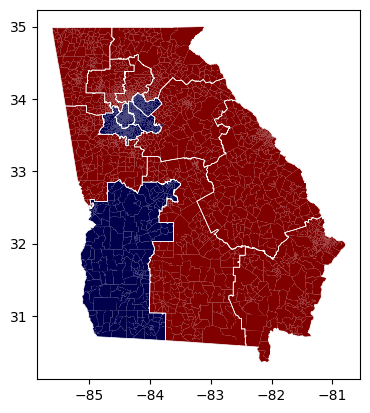

In [63]:
fig, ax = plt.subplots()

# Plot the units with the vote percentage as color
ga_data_gdf.plot(column = "Winner-2021", ax=ax, cmap = "seismic")

# Overlay districts
ga_2021_gdf.boundary.plot(ax=ax, color='white', linewidth=0.5)

# Save the figure as a PNG file
plt.savefig('./graphics/ga-2021-winner-dist.png', dpi=300, bbox_inches='tight') 

### 2023 Congressional Map
We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2023 congressional districting map. Since we are using the same senate election as above, the candidates in 2022 were the same: Democrat Raphael Warnock (G22USSDWAR) and Republican Herschel Junior Walker (G22USSRWAL).

In [22]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_data_gdf.groupby('DIST2023')[['R22USSDWAR', 'R22USSRWAL']].sum()

# Determine the winning party in each district
district_totals['Winner-2023'] = np.where(district_totals['R22USSDWAR'] > district_totals['R22USSRWAL'], "Democrat", "Republican")

# Reset index to turn District back into a column (optional)
district_totals_2023 = district_totals.reset_index()

print(district_totals_2023)

    DIST2023  R22USSDWAR  R22USSRWAL Winner-2023
0          0    124453.0     98795.0    Democrat
1          1     99550.0    177410.0  Republican
2          2    107581.0    135382.0  Republican
3          3     86310.0    156118.0  Republican
4          4    108971.0    137594.0  Republican
5          5     79529.0    166740.0  Republican
6          6    201984.0     55351.0    Democrat
7          7    111888.0    166912.0  Republican
8          8    225999.0     24624.0    Democrat
9          9    178661.0     40451.0    Democrat
10        10    181207.0     61114.0    Democrat
11        11    118131.0    167250.0  Republican
12        12     84545.0    168727.0  Republican
13        13    111785.0    164776.0  Republican


In [23]:
# Count the number of districts won by each party
winner_summary_2023 = district_totals_2023['Winner-2023'].value_counts()

print(winner_summary_2023)

Winner-2023
Republican    9
Democrat      5
Name: count, dtype: int64


In [24]:
ga_data_gdf = ga_data_gdf.merge(district_totals_2023[["DIST2023", "Winner-2023"]], on='DIST2023', how='left')

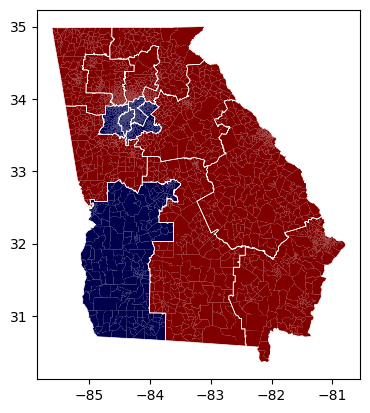

In [64]:
fig, ax = plt.subplots()

# Plot the units with the vote percentage as color
ga_data_gdf.plot(column = "Winner-2023", ax=ax, cmap = "seismic")

# Overlay districts
ga_2023_gdf.boundary.plot(ax=ax, color='white', linewidth=0.5)

# Save the figure as a PNG file
plt.savefig('./graphics/ga-2023-winner-dist.png', dpi=300, bbox_inches='tight') 

### Setting up and running our Random Walk

In [27]:
ga_graph = Graph.from_file("save-new-data/GA-election-census-data-by-precincts.shp")

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [28]:
# Make an initial districting plan

num_dist = 14 # Number of Congressional Districts in Georgia
tot_pop = sum([ga_graph.nodes()[v]['TOTPOP'] for v in ga_graph.nodes()])
ideal_pop = tot_pop/num_dist
pop_tolerance = 0.02
initial_plan = recursive_tree_part(ga_graph, range(num_dist), ideal_pop, 'TOTPOP', pop_tolerance, 10)

The cases against Georgia's congressional districting plan claimed that the plan was an unconstitutional racial gerrymander by violating Section 2 of the Voting Rights Act. For that reason we will examine the black population in addition to the senate election.

In [29]:
#Set up partition object
initial_partition = Partition(
    ga_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("R22USSRWAL", alias = "R Votes"), 
        "D Votes": Tally("R22USSDWAR", alias = "D Votes")
    }
) 

In [30]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [31]:
# We contrain the opulation to say with the tolarance we set for an ideal district population
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [32]:
# Now we create our chain
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [33]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = [] 
dvpop = []

for current_plan in our_random_walk:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    # Calculate the percentage of democratic voters for each district at each step
    dv_this_step = []
    for i in range(num_dist):
        dv_perc = current_plan["D Votes"][i]/ current_plan["district population"][i]
        dv_this_step.append(dv_perc)
    dv_this_step.sort()
    dvpop.append(bpop_this_step)

bpop_rand = np.array(bpop)
dvpop_rand = np.array(dvpop)

### Analysis

In the both the 2021 and 2023 congressional districting plans there were 5 district that elected democratic representatives for the House. Let's see how many democratic districts are likely within the ensemble.

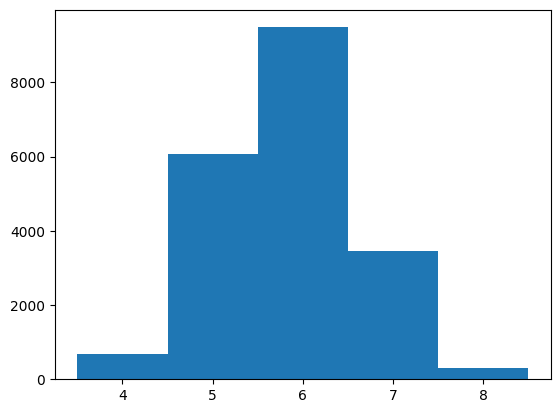

In [65]:
plt.figure()
plt.hist(d_ensemble, bins = [x + 0.5 for x in range(min(set(d_ensemble)) - 1, max(set(d_ensemble)) + 1)])

# Save the figure as a PNG file
plt.savefig('./graphics/ga-rand-d-emsemble.png', dpi=300, bbox_inches='tight') 

We see that 6 is most likely, but 5 districts is close.

Now, let's look at black majority districts.

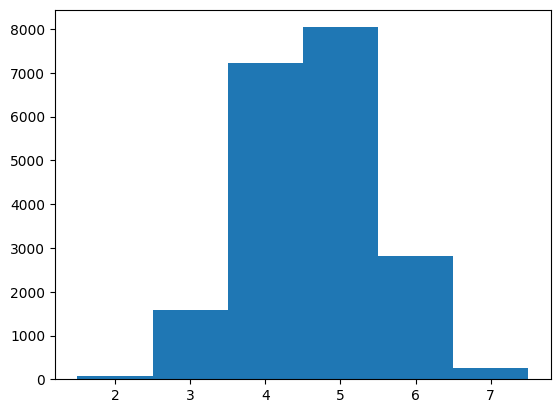

In [66]:
plt.figure()
plt.hist(bmaj_ensemble, bins = [x + 0.5 for x in range(min(set(bmaj_ensemble)) - 1, max(set(bmaj_ensemble)) + 1)])

# Save the figure as a PNG file
plt.savefig('./graphics/ga-rand-bmaj-emsemble.png', dpi=300, bbox_inches='tight') 

The ensemble has mostly 4 Black-majority districts but 5 is pretty close. Now let's see how many exist in the 2021 and 2023 congressional plan.

In [36]:
ga_2023_graph = Graph.from_file("congress-2023-shape/Congress-2023-shape.shp")
ga_2021_graph = Graph.from_file("congress-prop1-2021-shape/CONGRESS-PROP1-2021-shape.shp")

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column LOCKED!
  warnings.warn("NA values found in column {}!".format(column))
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column NAME!
  warnings.warn("NA 

In [37]:
plans = [ga_2021_graph, ga_2023_graph]
bmaj_districts = {}

for p in plans:
    bpop_district = {}
    pop_district = {}

    for i in p.nodes():
        if i not in bpop_district:
            bpop_district[i] = p.nodes()[i]["NH_BLK"]
            pop_district[i] = p.nodes()[i]["POPULATION"]
        else:
            bpop_district[i] += p.nodes()[i]["NH_BLACK"]
            pop_district[i] += p.nodes()[i]["POPULATION"]

    num_maj_black = 0
    for j in range(1, 13):
        if bpop_district[j] / pop_district[j] >= 0.37: 
            num_maj_black += 1
    
    bmaj_districts[p] = num_maj_black

In [38]:
print("Black majority districts in 2021 plan:", bmaj_districts[ga_2021_graph])
print("Black majority districts in 2023 plan:", bmaj_districts[ga_2023_graph])

Black majority districts in 2021 plan: 3
Black majority districts in 2023 plan: 4


So it seems like the 2021 was definently racially gerrymandered, however, the 2023 could go either way since the ensemble demonstrated that 4 black-majority districts was basically as likely as 5 districts. Regarding partisan gerrymandering, both 2021 and 2023 had 5 democratic districts and our ensemble had 6, so it seems like the plans were also partisanly gerrymandered.

### Mixing Time

#### Random Walk from 2021 Plan

In [39]:
#Set up partition object
initial_partition = Partition(
    ga_graph, # dual graph
    assignment = "DIST2021", # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("R22USSRWAL", alias = "R Votes"), 
        "D Votes": Tally("R22USSDWAR", alias = "D Votes")
    }
) 

In [40]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [41]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [42]:
random_walk_2021 = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [43]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = [] 
dvpop = []

for current_plan in random_walk_2021:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    # Calculate the percentage of democratic voters for each district at each step
    dv_this_step = []
    for i in range(num_dist):
        dv_perc = current_plan["D Votes"][i]/ current_plan["district population"][i]
        dv_this_step.append(dv_perc)
    dv_this_step.sort()
    dvpop.append(bpop_this_step)

bpop_2021 = np.array(bpop)
dvpop_2021 = np.array(dvpop)

#### Random Walk from 2023 Plan

In [44]:
#Set up partition object
initial_partition = Partition(
    ga_graph, # dual graph
    assignment = "DIST2023", # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("R22USSRWAL", alias = "R Votes"), 
        "D Votes": Tally("R22USSDWAR", alias = "D Votes")
    }
) 

In [45]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [46]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [47]:
random_walk_2023 = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [48]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = [] 
dvpop = []

for current_plan in random_walk_2023:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    # Calculate the percentage of democratic voters for each district at each step
    dv_this_step = []
    for i in range(num_dist):
        dv_perc = current_plan["D Votes"][i]/ current_plan["district population"][i]
        dv_this_step.append(dv_perc)
    dv_this_step.sort()
    dvpop.append(bpop_this_step)

bpop_2023 = np.array(bpop)
dvpop_2023 = np.array(dvpop)

#### Compare a boxplot of the results from black population and for democratic voting population

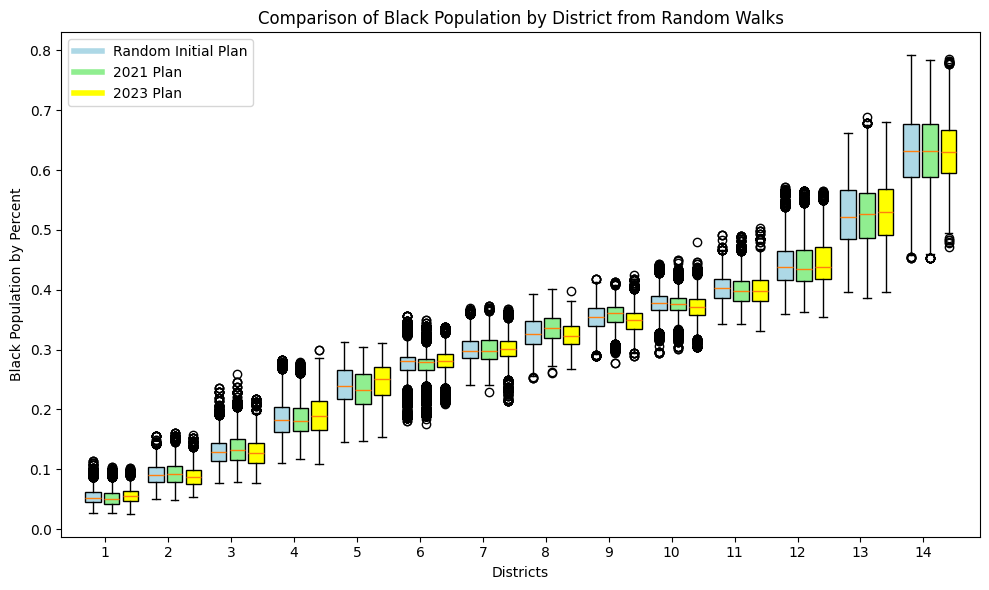

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_2021 = [x + 0.1 for x in range(1, num_dist + 1)]
positions_2023 = [x + 0.4 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan
ax.boxplot(bpop_rand, positions=positions_rand, widths=0.25, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(bpop_2021, positions=positions_2021, widths=0.25, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Plot boxplots for black population from 2023 initial plan
ax.boxplot(bpop_2023, positions=positions_2023, widths=0.25, patch_artist=True, boxprops=dict(facecolor="yellow"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4),
           plt.Line2D([0], [0], color="yellow", lw=4)],
          ['Random Initial Plan', '2021 Plan', '2023 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Black Population by Percent')
ax.set_title('Comparison of Black Population by District from Random Walks')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/ga-rws-bpop.png', dpi=300, bbox_inches='tight')

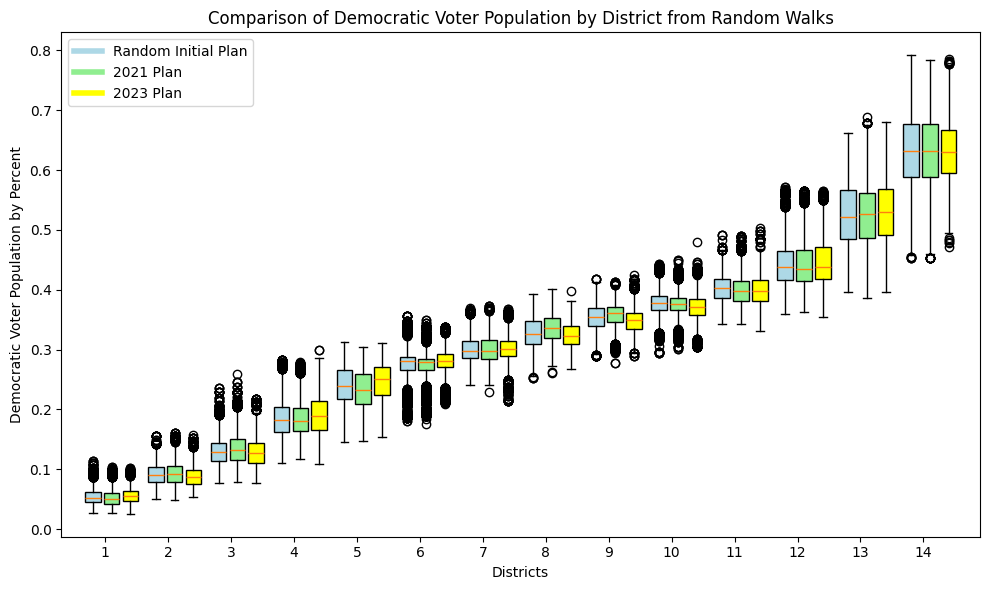

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_2021 = [x + 0.1 for x in range(1, num_dist + 1)]  
positions_2023 = [x + 0.4 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan
ax.boxplot(dvpop_rand, positions=positions_rand, widths=0.25, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(dvpop_2021, positions=positions_2021, widths=0.25, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Plot boxplots for black population from 2023 initial plan
ax.boxplot(dvpop_2023, positions=positions_2023, widths=0.25, patch_artist=True, boxprops=dict(facecolor="yellow"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4),
           plt.Line2D([0], [0], color="yellow", lw=4)],
          ['Random Initial Plan', '2021 Plan', '2023 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Democratic Voter Population by Percent')
ax.set_title('Comparison of Democratic Voter Population by District from Random Walks')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/ga-rws-dvpop.png', dpi=300, bbox_inches='tight')

### Run random initial one for more 20,000 steps instead of 10,0000

In [56]:
#Set up partition object
initial_partition = Partition(
    ga_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("R22USSRWAL", alias = "R Votes"), 
        "D Votes": Tally("R22USSDWAR", alias = "D Votes")
    }
) 

In [57]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [58]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [59]:
random_walk_more_steps = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 20000
)

In [60]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = []
dv_pop = []

for current_plan in random_walk_more_steps:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    # Calculate the percentage of democratic voters for each district at each step
    dv_this_step = []
    for i in range(num_dist):
        dv_perc = current_plan["D Votes"][i]/ current_plan["district population"][i]
        dv_this_step.append(dv_perc)
    dv_this_step.sort()
    dvpop.append(bpop_this_step)

bpop_more_steps = np.array(bpop)
dvpop_more_steps = np.array(dvpop)

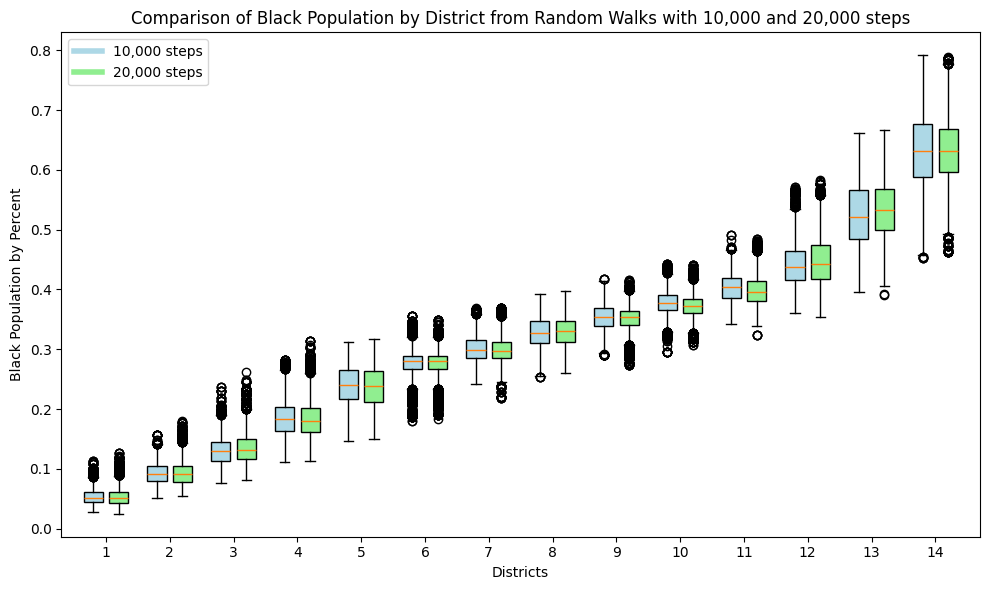

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan with 10000 steps
ax.boxplot(bpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(bpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['10,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Black Population by Percent')
ax.set_title('Comparison of Black Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/ga-steps-bpop.png', dpi=300, bbox_inches='tight')

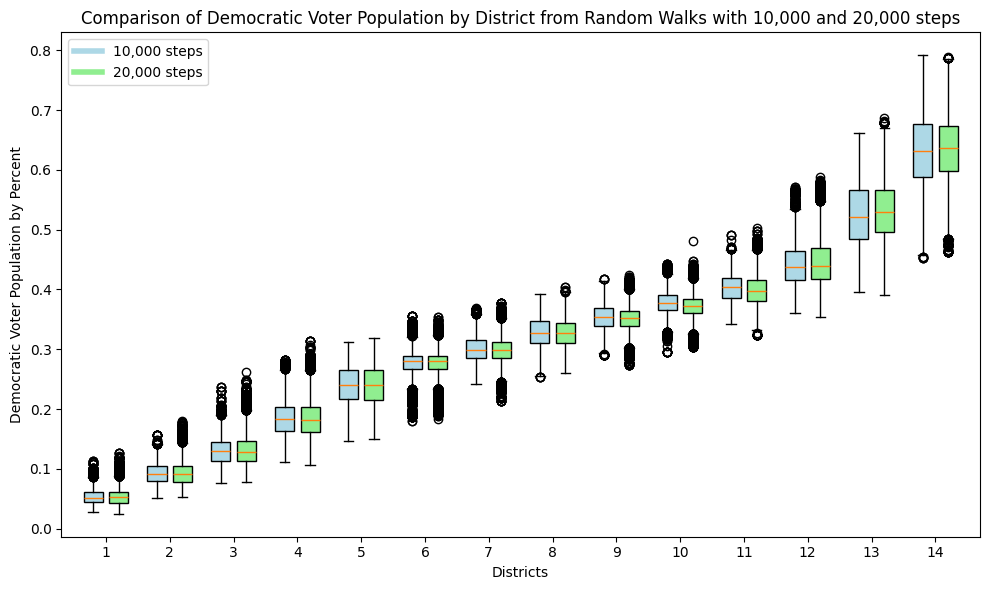

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)]  
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan with 10000 steps
ax.boxplot(dvpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(dvpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['10,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Democratic Voter Population by Percent')
ax.set_title('Comparison of Democratic Voter Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/ga-steps-dvpop.png', dpi=300, bbox_inches='tight')

Looks like our random walk ran for long enough.